In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class Encoder_large(nn.Module):  # Embedding module
    def __init__(self, encoder_channel):
        super().__init__()
        self.encoder_channel = encoder_channel
        self.first_conv = nn.Sequential(
            nn.Conv1d(3, 256, 1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 512, 1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 1024, 1),
        )
        self.second_conv = nn.Sequential(
            nn.Conv1d(2048, 2048, 1),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Conv1d(2048, self.encoder_channel, 1),
        )

    def forward(self, point_groups):
        """
        point_groups : B G N 3
        -----------------
        feature_global : B G C
        """
        bs, g, n, _ = point_groups.shape
        point_groups = point_groups.reshape(bs * g, n, 3)
        print(point_groups.shape)
        # encoder
        feature = self.first_conv(point_groups.transpose(2, 1))  # BG 256 n
        print(feature.shape)
        feature_global = torch.max(feature, dim=2, keepdim=True)[0]  # BG 256 1
        print(feature_global.shape)
        feature = torch.cat(
            [feature_global.expand(-1, -1, n), feature], dim=1
        )  # BG 512 n
        print(feature.shape)
        feature = self.second_conv(feature)  # BG 1024 n
        print(feature.shape)
        feature_global = torch.max(feature, dim=2, keepdim=False)[0]  # BG 1024
        print(feature_global.shape)
        return feature_global.reshape(bs, g, self.encoder_channel)


x = torch.randn(2, 2, 1024, 3)
y = Encoder_large(256)(x)
print(y.shape)

torch.Size([4, 1024, 3])
torch.Size([4, 1024, 1024])
torch.Size([4, 1024, 1])
torch.Size([4, 2048, 1024])
torch.Size([4, 256, 1024])
torch.Size([4, 256])
torch.Size([2, 2, 256])


# Transformers
based on the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Dosovitskiy et al. (2021)

![image.png](../images/transformers/t1.png)

## Notes
remember transformers are not convolutional networks, they are attention networks
they are data-hungry, so they need a lot of data to train  
(Rule of thumb: A lot of data -> Transformers, not a lot of data -> CNNs)

## References
--[Pytorch Tutorial](https://www.learnpytorch.io/08_pytorch_paper_replicating/#104-train-feature-extractor-vit-model)

## Videos
- [ViT: An Image is Worth 16x16 Words | Paper Explained](https://www.youtube.com/watch?v=TrdevFK_am4)
- [Transformers in Vision: From Zero to Hero](https://www.youtube.com/watch?v=J-utjBdLCTo&t=1244s&ab_channel=AICamp)
- [Vision Transformer and its Applications](https://www.youtube.com/watch?v=hPb6A92LROc&t=1466s&ab_channel=OpenDataScience)
- [Vision Transformers (ViT)](https://www.youtube.com/watch?v=tjpW_BY8y3g&t=2890s&ab_channel=DanielBourkearXiv)
- [ViT (Vision Transformer) Implementation from Scratch with PyTorch!](https://www.youtube.com/watch?v=nZ22Ecg9XCQ&t=2242s&ab_channel=AhmadChalhoub)

In [3]:
# import
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import Resize, ToTensor
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms.functional import to_pil_image
from einops import rearrange, reduce, repeat

# add to patsS
import sys

sys.path.append(".." if ".." not in sys.path else "")
from src import data as dt, res as rs

ModuleNotFoundError: No module named 'einops'

In [2]:
# Data module for simple image classification [3 classes]
import os
import zipfile

from pathlib import Path

import requests


def download_data(source: str, destination: str, remove_source: bool = True) -> Path:
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path


image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
)
image_path

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()


def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS,
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
    )

    return train_dataloader, test_dataloader, class_names


IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ]
)
print(f"Manually created transforms: {manual_transforms}")

# Set the batch size
BATCH_SIZE = (
    32  # this is lower than the ViT paper but it's because we're starting small
)
train_dir = image_path / "train"
test_dir = image_path / "test"
# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

[INFO] data\pizza_steak_sushi directory exists, skipping download.
Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


(<torch.utils.data.dataloader.DataLoader at 0x1eb0bc67790>,
 ['pizza', 'steak', 'sushi'])

Text(0.5, 1.0, 'Label: pizza')

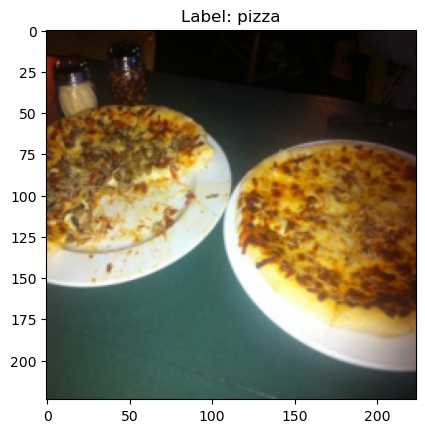

In [3]:
# get an image from training set
img, label = train_dataloader.dataset[0]
# plot image and add label
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {class_names[label]}")

## 1st Step
Patch the image into embeddings

In [4]:
class PatchEmbedding(nn.Module):
    """
    Image to Patch Embedding

    Args:
        in_channels: number of input channels
        patch_size: patch size
        embed_dim: embedding dimension

    Attributes:
        projection: convolutional layer for embedding

    Shape:
        - Input: (B, C, H, W)
        - Output: (B, num_patches, embed_dim)

    Examples:
        >>> x = torch.randn(1, 3, 224, 224)
        >>> model = PatchEmbedding()
        >>> y = model(x)
        >>> print(y.shape)
        torch.Size([1, 196, 768])
    """

    def __init__(self, in_channels=3, patch_size=16, embed_dim=768):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.projection = nn.Sequential(
            nn.Conv2d(
                in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
            ),  # in_channels, out_channels, kernel_size, stride
            nn.Flatten(start_dim=2),
        )

    def forward(self, x):
        # x.shape = (B, C, H, W)
        x = self.projection(x)  # x.shape = (B, embed_dim, num_patches)
        x = x.transpose(
            1, 2
        )  # x.shape = (B, num_patches = H*W/patch_size^2, embed_dim=patch_size^2 * C)
        return x


x = torch.randn(25, 3, 224, 224)
model = PatchEmbedding(in_channels=3, patch_size=16, embed_dim=768)
y = model(x)
print(y.shape)

torch.Size([25, 196, 768])


In [5]:
class Attention(nn.Module):
    """
    Compute the scaled dot-product attention

    Args:
        dim: dimension of the input
        heads: number of heads

    Attributes:
        Wq: linear projection of the input (query)
        Wk: linear projection of the input (key)
        Wv: linear projection of the input (value)
        scale: scale factor
        Wo: linear projection of the output

    Shape:
        x: (batch_size, seq_len, dim)
        mask: (batch_size, seq_len, seq_len)
        Q: (batch_size, heads, seq_len, dim // heads)
        K: (batch_size, heads, seq_len, dim // heads)
        V: (batch_size, heads, seq_len, dim // heads)
        QK: (batch_size, heads, seq_len, seq_len)
        H: (batch_size, heads, seq_len, dim // heads)
        A: (batch_size, heads, seq_len, dim // heads)
        x: (batch_size, seq_len, dim)

    Examples::
        >>> x = torch.randn(25, 197, 768)
        >>> attn = Attention(x.shape[-1])
        >>> attn(x).shape
        torch.Size([25, 197, 768])
    """

    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        # 1. Linear projection of the input
        self.Wq = nn.Linear(dim, dim, bias=False)  # query
        self.Wk = nn.Linear(dim, dim, bias=False)  # key
        self.Wv = nn.Linear(dim, dim, bias=False)  # value
        # 2. Scaled dot-product attention
        self.scale = dim**-0.5
        # 3. Output projection
        self.Wo = nn.Linear(dim, dim, bias=False)
        # init attention weights
        self.attn_weights = None

    def SplitHeads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)

        Args:
            x: (batch_size, seq_len, dim)
            batch_size: batch size

        Shape:
            x: (batch_size, heads, seq_len, dim // heads)

        Examples::
            >>> x = torch.randn(25, 197, 768)
            >>> attn = Attention(x.shape[-1])
            >>> attn.SplitHeads(x, 25).shape
            torch.Size([25, 8, 197, 96]) # 8*96 = 768
        """
        x = x.reshape(batch_size, -1, self.heads, x.shape[-1] // self.heads)
        return x.permute(0, 2, 1, 3)

    def GroupHeads(self, x, batch_size):
        """
        Concatenate the heads, so that the dimension of the output is the same as the input

        Args:
            x: (batch_size, heads, seq_len, dim // heads)
            batch_size: batch size

        Shape:
            x: (batch_size, seq_len, dim)

        Examples::
            >>> x = torch.randn(25, 8, 197, 96)
            >>> attn = Attention(x.shape[-1])
            >>> attn.GroupHeads(x, 25).shape
            torch.Size([25, 197, 768])
        """
        x = x.permute(0, 2, 1, 3).reshape(batch_size, -1, self.heads * x.shape[-1])
        return x

    def ScaleDotProductAttention(self, Q, K, V, mask=None):
        # Compute the scaled dot-product attention
        QK = (
            torch.einsum("bhqd, bhkd -> bhqk", Q, K) * self.scale
        )  # H = QK^T / sqrt(d_k)
        # Apply the mask
        if mask is not None:
            QK = QK.masked_fill(mask == 0, float("-1e20"))
        # Apply softmax
        QK = torch.softmax(QK, dim=-1)  # H = softmax(QK^T/sqrt(d_k))
        # Apply attention
        V = torch.einsum("bhqk, bhkd -> bhqd", QK, V)  # A = HV
        return V

    def forward(self, x, mask=None):
        batch_size = x.shape[0]
        # 1. Linear projection of the input (query, key, value)
        Q = self.Wq(x)  # Size: (batch_size, seq_len, dim)
        K = self.Wk(x)
        V = self.Wv(x)
        # 2. Split the last dimension into (heads X depth)
        Q = self.SplitHeads(Q, batch_size)  # Q = Wq * x
        K = self.SplitHeads(K, batch_size)  # K = Wk * x
        V = self.SplitHeads(V, batch_size)  # V = Wv * x
        # 3. Scaled dot-product attention
        x = self.ScaleDotProductAttention(
            Q, K, V, mask
        )  # A = HV:size (batch_size, heads, seq_len, dim // heads)
        # 4. Group the heads
        x = self.GroupHeads(x, batch_size)  # x = concat(A_1, ..., A_h)
        self.attn_weights = x
        # 5. Output projection
        x = self.Wo(x)  # x = Wo * x
        return x, self.attn_weights


x = torch.randn(25, 197, 768)
model = Attention(x.shape[-1])
model(x)[0].shape

torch.Size([25, 197, 768])

In [7]:
class PreNorm(nn.Module):
    """
    PreNorm is a wrapper class for applying normalization before applying a function to the input.

    Args:
        dim (int): dimension of the input
        fn (function): function to be applied to the input

    Attributes:
        norm (nn.LayerNorm): normalization layer for input of each dim
        fn (function): function to be applied to the input

    Returns:
        output of the function applied to the normalized input

    Examples::
        >>> x = torch.randn(25, 3, 224, 224)
        >>> print(x.shape)
        >>> print(x.view(x.shape[0], -1).shape)
        >>> x_seq = x.view(x.shape[0], -1)
        >>> prenorm = PreNorm(3 * 224 * 224, nn.Linear(3 * 224 * 224, 100))
        >>> y = prenorm(x_seq)
        >>> print(y.shape)
        torch.Size([25, 3, 224, 224])
        torch.Size([25, 150528])
        torch.Size([25, 100])
    """

    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(
            dim
        )  # LayerNorm is a normalization layer for input of each dim
        self.fn = fn  # fn is the function to be applied to the input

    def forward(self, x, **kwargs):
        return self.fn(
            self.norm(x), **kwargs
        )  # apply the function to the normalized input

In [8]:
class FeedForward(nn.Module):
    """
    FeedForward module consists of two linear transformations with a GELU activation in between

    Args:
        dim (int): input and output dimension
        hidden_dim (int): hidden dimension
        dropout (float): dropout probability

    Shape:
        x: (batch_size, seq_len, dim)
        output: (batch_size, seq_len, dim)

    Return:
        output: (batch_size, seq_len, dim)

    Examples:
        >>> x = torch.randn(25, 196, 768)
        >>> feed_forward = FeedForward(x.shape[-1], x.shape[-1]*4, 0.1)
        >>> y = feed_forward(x)
        >>> print(y.shape)
        torch.Size([25, 196, 768])

    """

    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.linear_1 = nn.Linear(dim, hidden_dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_dim, dim)

    def forward(self, x):
        x = self.linear_1(x)  # (batch_size, seq_len, hidden_dim)
        x = self.gelu(x)  # GELU activation function
        x = self.dropout(x)  # (batch_size, seq_len, hidden_dim)
        x = self.linear_2(x)  # (batch_size, seq_len, dim)
        x = self.dropout(x)  # (batch_size, seq_len, dim)
        return x


x = torch.randn(25, 196, 768)
feed_forward = FeedForward(x.shape[-1], x.shape[-1] * 4, 0.1)
y = feed_forward(x)
print(y.shape)
# print(y[0])
# print(y[1])

torch.Size([25, 196, 768])


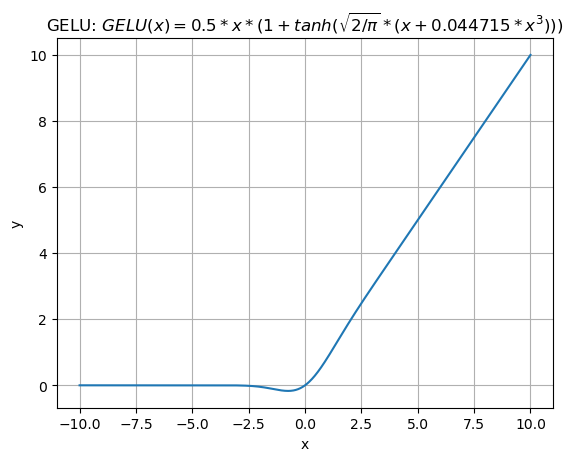

In [9]:
# create a GELU
import math


def gelu(x):
    return (
        0.5
        * x
        * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    )


# plot gelu
x = torch.linspace(-10, 10, 1000)
y = gelu(x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title(
    "GELU: $\mathit{GELU}(x) = 0.5 * x * (1 + tanh(\sqrt{2 / \pi} * (x + 0.044715 * x^3)))$"
)
plt.grid()

In [10]:
class Residual(nn.Module):
    """
    Residual block

    Args:
        fn: function to apply

    Returns:
        function: residual block

    Example::
        >>> residual = Residual(nn.Conv2d(3, 3, 3, padding=1))
        >>> x = torch.randn(25, 3, 224, 224)
        >>> print(residual(x).shape)
        torch.Size([25, 3, 224, 224])

    """

    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

In [14]:
class ViT(nn.Module):
    """
    Vision Transformer

    Args:
        channels (int): Number of channels in the input image
        img_size (int): Size of input image
        patch_size (int): Size of each patch
        embedding_dim (int): Dimension of embedding vector
        n_layers (int): Number of transformer layers
        n_heads (int): Number of attention heads
        n_classes (int): Number of output classes
        dropout (float): Dropout probability
        batch_size (int): Batch size

    Attributes:
        patch_embedding (nn.Module): Patch embedding layer
        num_patches (int): Number of patches
        positional_embedding (nn.Parameter): Positional embedding
        cls_token (nn.Parameter): Classification token
        class_embedding (nn.Parameter): Classification embedding
        layers (nn.ModuleList): Transformer layers
        head (nn.Sequential): Classification head

    Shape:
        - Input: (batch_size, channels, img_size, img_size)
        - Output: (batch_size, n_classes)

    Returns:
        torch.Tensor: Classification logits

    Examples::
        >>> x = torch.randn(32, 3, 224, 224)
        >>> model = ViT(
            channels=3,
            img_size=224,
            patch_size=16,
            embedding_dim=768,
            n_layers=12,
            n_heads=12,
            n_classes=3,
            dropout=0.1,
            batch_size=32
        )
    """

    def __init__(
        self,
        channels=3,
        img_size=224,
        patch_size=16,
        embedding_dim=768,
        n_layers=6,
        n_heads=6,
        n_classes=2,
        dropout=0.1,
        batch_size=32,
    ):
        super().__init__()
        self.channels = channels
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.embedding_dim = embedding_dim
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.output_image = None
        # Patch embedding
        self.patch_embedding = PatchEmbedding(
            in_channels=self.channels,
            patch_size=self.patch_size,
            embed_dim=self.embedding_dim,
        )

        self.num_patches = self.height * self.width // self.patch_size**2
        # Positional emredding
        self.positional_embedding = nn.Parameter(
            torch.randn(1, self.num_patches + 1, self.embedding_dim)
        )  # 1 for batch size
        # size of positional_embedding:
        # self.cls_token = nn.Parameter(torch.randn(self.batch_size, 1, self.embedding_dim)) # 1 for batch size
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, self.embedding_dim), requires_grad=True
        )
        # Transformer encoder ""
        self.layers = nn.ModuleList([])
        for _ in range(self.n_layers):
            self.layers.append(
                nn.ModuleList(
                    [
                        (
                            PreNorm(
                                self.embedding_dim,
                                Attention(self.embedding_dim, self.n_heads),
                            )
                        ),
                        (
                            PreNorm(
                                self.embedding_dim,
                                FeedForward(
                                    self.embedding_dim, self.embedding_dim * 4, dropout
                                ),
                            )
                        ),
                    ]
                )
            )

        # Classification head
        self.head = nn.Sequential(
            nn.LayerNorm(self.embedding_dim),
            nn.Linear(self.embedding_dim, self.embedding_dim * 2),
            nn.ReLU(),
            nn.Linear(self.embedding_dim * 2, self.n_classes),
            # nn.Softmax(dim=-1) # dim=-1: last dimension
        )  # size of head: 768x37 (37 classes)

    def forward(self, x):
        # get slc
        self.batch_size = x.shape[0]
        self.cls_token = self.class_embedding.expand(self.batch_size, -1, -1)
        # Patch embedding
        x = self.patch_embedding(x)
        print(x.shape)
        b, n, _ = x.shape
        # Positional embedding
        x = torch.cat((self.cls_token, x), dim=1)
        x += self.positional_embedding
        # init weights
        self.attn_weights = []
        # Transformer encoder
        for attn, ff in self.layers:
            attn_x, attn_weights_x = attn(x)
            x = attn_x + x
            x = ff(x) + x
            self.attn_weights.append(attn_weights_x)
        # Classification head of all batches
        self.output_image = x[:, 1:]
        x = self.head(x[:, 0])
        return x, self.output_image, self.attn_weights


x = torch.randn(32, 3, 224, 224)
model = ViT(
    channels=3,
    img_size=224,
    patch_size=16,
    embedding_dim=768,
    n_layers=6,
    n_heads=6,
    n_classes=3,
    dropout=0.1,
    batch_size=32,
)
y, output_image, attn_weights = model(x)
print(y.shape)

torch.Size([32, 196, 768])
torch.Size([32, 3])


In [20]:
x = torch.randn(2, 1, 1024, 3)
y = Encoder_large(256)(x)
print(y.shape)

torch.Size([2, 1024, 3])
torch.Size([2, 1024, 1024])
torch.Size([2, 1024, 1])
torch.Size([2, 2048, 1024])
torch.Size([2, 256, 1024])
torch.Size([2, 256])
torch.Size([2, 1, 256])


In [21]:
# pass y through Vit
vit_small = ViT(
    channels=1,
    img_size=1024,
    patch_size=16,
    embedding_dim=256,
    n_layers=6,
    n_heads=6,
    n_classes=3,
    dropout=0.1,
    batch_size=2,
)
y_, output_image, attn_weights = vit_small(y)

RuntimeError: Given groups=1, weight of size [256, 1, 16, 16], expected input[1, 2, 1, 256] to have 1 channels, but got 2 channels instead

In [ ]:
# now given the encoder
x = torch.randn(2, 3, 224, 224)

In [11]:
device = "cpu"  # it doesnt run on gpu due to the size of the model
seed = 42  # random seed
batch_size = 32  # batch size
# set random seed
torch.manual_seed(seed)
# model
model = ViT(
    channels=3,
    img_size=224,
    patch_size=16,
    embedding_dim=768,
    n_layers=12,
    n_heads=12,
    n_classes=3,
    dropout=0.1,
    batch_size=512,
).to(device)
# optimizer
learning_rate = 8e-4
# make learning rate decay
lr_decay = 0.99
# weight decay
wg_decay = 0.1
# optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=wg_decay
)
# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=lr_decay
)  # decay LR by a factor of lr_decay every epoch
# loss function
criterion = nn.CrossEntropyLoss()
# epochs
epochs = 4
# print 5 times in training
print_times = epochs
print_every = epochs // print_times
e_losses = []
accs = []
# train
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    print("=====================================")
    epoch_losses = []
    model.train()  # set model to training phase
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        # print batch index
        print(f"Batch {batch_idx + 1} of {len(train_dataloader)}")
        # move data to device
        images, labels = images.to(device), labels.to(device)
        #  zero the parameter gradients
        optimizer.zero_grad()
        # forward propagation
        outputs, _, _ = model(images)
        # calculate loss
        loss = criterion(outputs, labels)
        # backward propagation
        loss.backward()
        # update parameters
        optimizer.step()
        # add lr scheduler
        lr_scheduler.step()
        # store loss
        epoch_losses.append(loss.item())
    # print loss
    print(f"Loss: {sum(epoch_losses) / len(epoch_losses)}")
    # store epoch loss
    e_losses.append(sum(epoch_losses) / len(epoch_losses))
    # print accuracy
    if (epoch + 1) % print_every == 0:
        print("Evaluating model")
        epoch_accs = []
        model.eval()
        for batch_idx, (images, labels) in enumerate(test_dataloader):
            # move data to device
            images, labels = images.to(device), labels.to(device)
            # forward propagation
            outputs, _, _ = model(images)
            # get predictions
            _, preds = torch.max(outputs, dim=1)
            # calculate accuracy
            acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
            # store accuracy
            epoch_accs.append(acc)
        print(f"Accuracy: {sum(epoch_accs) / len(epoch_accs)}")
        # store accuracy
        accs.append(sum(epoch_accs) / len(epoch_accs))

Epoch 1 of 4
Batch 1 of 8
Batch 2 of 8
Batch 3 of 8
Batch 4 of 8
Batch 5 of 8
Batch 6 of 8
Batch 7 of 8
Batch 8 of 8
Loss: 1.5362105891108513
Evaluating model
Accuracy: 0.4223484992980957
Epoch 2 of 4
Batch 1 of 8
Batch 2 of 8
Batch 3 of 8
Batch 4 of 8
Batch 5 of 8
Batch 6 of 8
Batch 7 of 8
Batch 8 of 8
Loss: 1.3890801817178726
Evaluating model
Accuracy: 0.32007575035095215
Epoch 3 of 4
Batch 1 of 8
Batch 2 of 8
Batch 3 of 8
Batch 4 of 8
Batch 5 of 8
Batch 6 of 8
Batch 7 of 8
Batch 8 of 8
Loss: 1.2001782655715942
Evaluating model
Accuracy: 0.3797348439693451
Epoch 4 of 4
Batch 1 of 8
Batch 2 of 8
Batch 3 of 8
Batch 4 of 8
Batch 5 of 8
Batch 6 of 8
Batch 7 of 8
Batch 8 of 8
Loss: 1.1412200182676315
Evaluating model
Accuracy: 0.4223484992980957


In [12]:
# lets save the model
path = "ViT_model.pth"
torch.save(model.state_dict(), path)

In [13]:
# make predictions
images, labels = next(iter(train_dataloader))
num = len(labels)
images = images.to(device)
with torch.no_grad():
    outputs, _, _ = model(images)
    _, predicted = torch.max(outputs.data, 1)
    acc = (predicted == labels).sum().item() / len(labels)

classes = class_names
print("Predicted: ", " ".join("%5s" % classes[predicted[j]] for j in range(num)))
print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(num)))
print("Accuracy: ", acc)

Predicted:  sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi sushi
GroundTruth:  sushi sushi sushi sushi sushi steak steak pizza sushi sushi pizza pizza steak steak pizza pizza sushi steak pizza sushi steak pizza sushi pizza sushi sushi pizza steak pizza sushi pizza steak
Accuracy:  0.40625


torch.Size([1, 3, 224, 224])
torch.Size([1, 3]) torch.Size([1, 196, 768]) torch.Size([1, 197, 768]) 12
torch.Size([1, 196, 768])
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Attention Map')

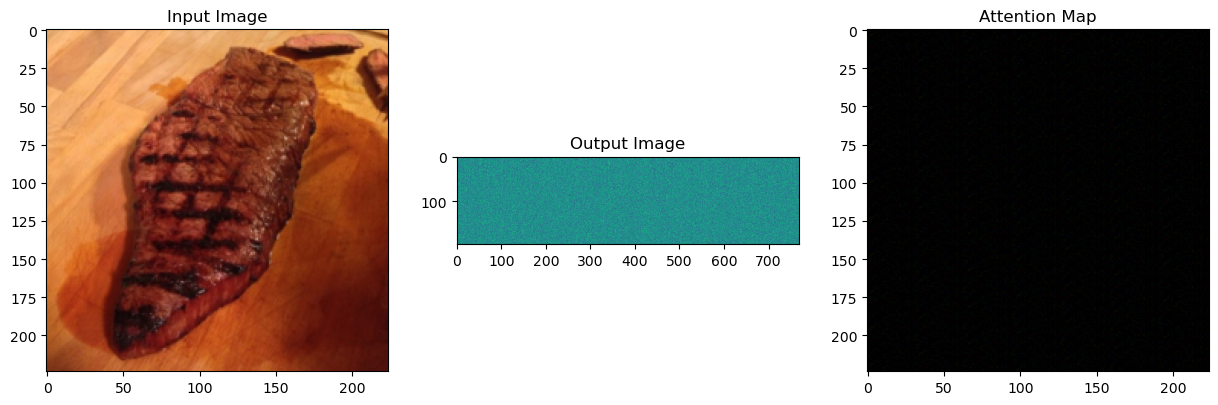

In [14]:
# get attention map from ViT
x = next(iter(train_dataloader))[0][0].unsqueeze(0).to(device)
print(x.shape)
y, output_image, attention_map = model(x)
# attention_map = torch.tensor(attention_map)
print(y.shape, output_image.shape, attention_map[0].shape, attention_map.__len__())
# attention_map = attention_map[0].cpu().detach().numpy()
# reshape attention map to 224x224 image
no = 6
attention_map[no] = attention_map[no][:, 1:]
print(attention_map[no].shape)
# attention_map = torch.nn.functional.interpolate(attention_map[0], size=(224, 224), mode='bilinear', align_corners=False)
attention_map = attention_map[no].reshape(3, 224, 224)
print(attention_map.shape)
# plot y, output_image, attention_map
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(x[0].cpu().detach().numpy().transpose(1, 2, 0))
ax[0].set_title("Input Image")
ax[1].imshow(output_image.cpu().detach().numpy().transpose(1, 2, 0))
ax[1].set_title("Output Image")
ax[2].imshow(attention_map.cpu().detach().numpy().transpose(1, 2, 0))
ax[2].set_title("Attention Map")

In [15]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = (
    torchvision.models.ViT_B_16_Weights.DEFAULT
)  # requires torchvision >= 0.13, "DEFAULT" means best available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
torch.manual_seed(42)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(
    device
)
# pretrained_vit # uncomment for model output

In [16]:
# # Print a summary using torchinfo (uncomment for actual output)
from torchsummary import summary

summary(pretrained_vit, (3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 768, 14, 14]         (590,592)
├─Encoder: 1-2                                [-1, 197, 768]            --
|    └─Dropout: 2-1                           [-1, 197, 768]            --
|    └─Sequential: 2-2                        [-1, 197, 768]            --
|    |    └─EncoderBlock: 3-1                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-2                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-3                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-4                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-5                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-6                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-7                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock:

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 768, 14, 14]         (590,592)
├─Encoder: 1-2                                [-1, 197, 768]            --
|    └─Dropout: 2-1                           [-1, 197, 768]            --
|    └─Sequential: 2-2                        [-1, 197, 768]            --
|    |    └─EncoderBlock: 3-1                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-2                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-3                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-4                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-5                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-6                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-7                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock:

In [17]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [18]:
# Setup dataloaders
batch_size = 512
(
    train_dataloader_pretrained,
    eval_dataloader_pretrained,
    class_names,
) = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=512,
)  # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [19]:
# train feature extractor
learning_rate = 1e-3
# optimizer
optimizer = torch.optim.AdamW(pretrained_vit.parameters(), lr=learning_rate)
# criterion
criterion = nn.CrossEntropyLoss()
# seed
torch.manual_seed(42)
# train
epochs = 3
# print every
pe = 1
# losses
train_losses = []
accs = []
for epoch in range(epochs):
    print("=" * 20)
    print(f"Epoch: {epoch+1}/{epochs}")
    pretrained_vit.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_dataloader_pretrained):
        data = data.to(device)
        target = target.to(device)
        # forward
        output = pretrained_vit(data)
        loss = criterion(output, target)
        _, preds = torch.max(output, 1)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loss
        train_loss += loss.item()
        # acc
        acc = torch.tensor(torch.sum(preds == target).item() / len(preds))
    # append loss
    train_losses.append(train_loss / len(train_dataloader))
    # print acc
    print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {acc:.4f}")
    if (epoch + 1) % pe == 0:
        epoch_accs = []
        loss = []
        pretrained_vit.eval()
        for batch_idx, (data, target) in enumerate(eval_dataloader_pretrained):
            data = data.to(device)
            target = target.to(device)
            # forward
            outputs = pretrained_vit(data)
            _, preds = torch.max(outputs, 1)
            # acc
            acc = torch.tensor(torch.sum(preds == target).item() / len(preds))
            # store acc
            epoch_accs.append(acc)
            # get loss
            loss.append(criterion(outputs, target).item())
        accs.append(sum(epoch_accs) / len(epoch_accs))
        print(f"Eval Loss: {sum(loss)/len(loss):.4f} | Eval Acc: {accs[-1]:.4f}")

Epoch: 1/3
Train Loss: 0.1436 | Train Acc: 0.2356
Eval Loss: 1.0584 | Eval Acc: 0.4667
Epoch: 2/3
Train Loss: 0.1252 | Train Acc: 0.5289
Eval Loss: 0.9194 | Eval Acc: 0.6400
Epoch: 3/3
Train Loss: 0.1090 | Train Acc: 0.7244
Eval Loss: 0.7983 | Eval Acc: 0.6667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([0, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 0, 0, 2, 0, 2, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        2, 0, 1], device='cuda:0')
tensor([0, 1, 2, 2, 1, 2, 2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 1,
        2, 1, 2, 0, 2, 2, 0, 1, 0, 2, 0, 1, 2, 1, 2, 1, 1, 2, 1, 0, 2, 2, 2, 0,
        0, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 1, 2, 1, 0, 2, 1,
        2, 0, 0], device='cuda:0')
Accuracy: 66.67%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

ValueError: num must be an integer with 1 <= num <= 36, not 37

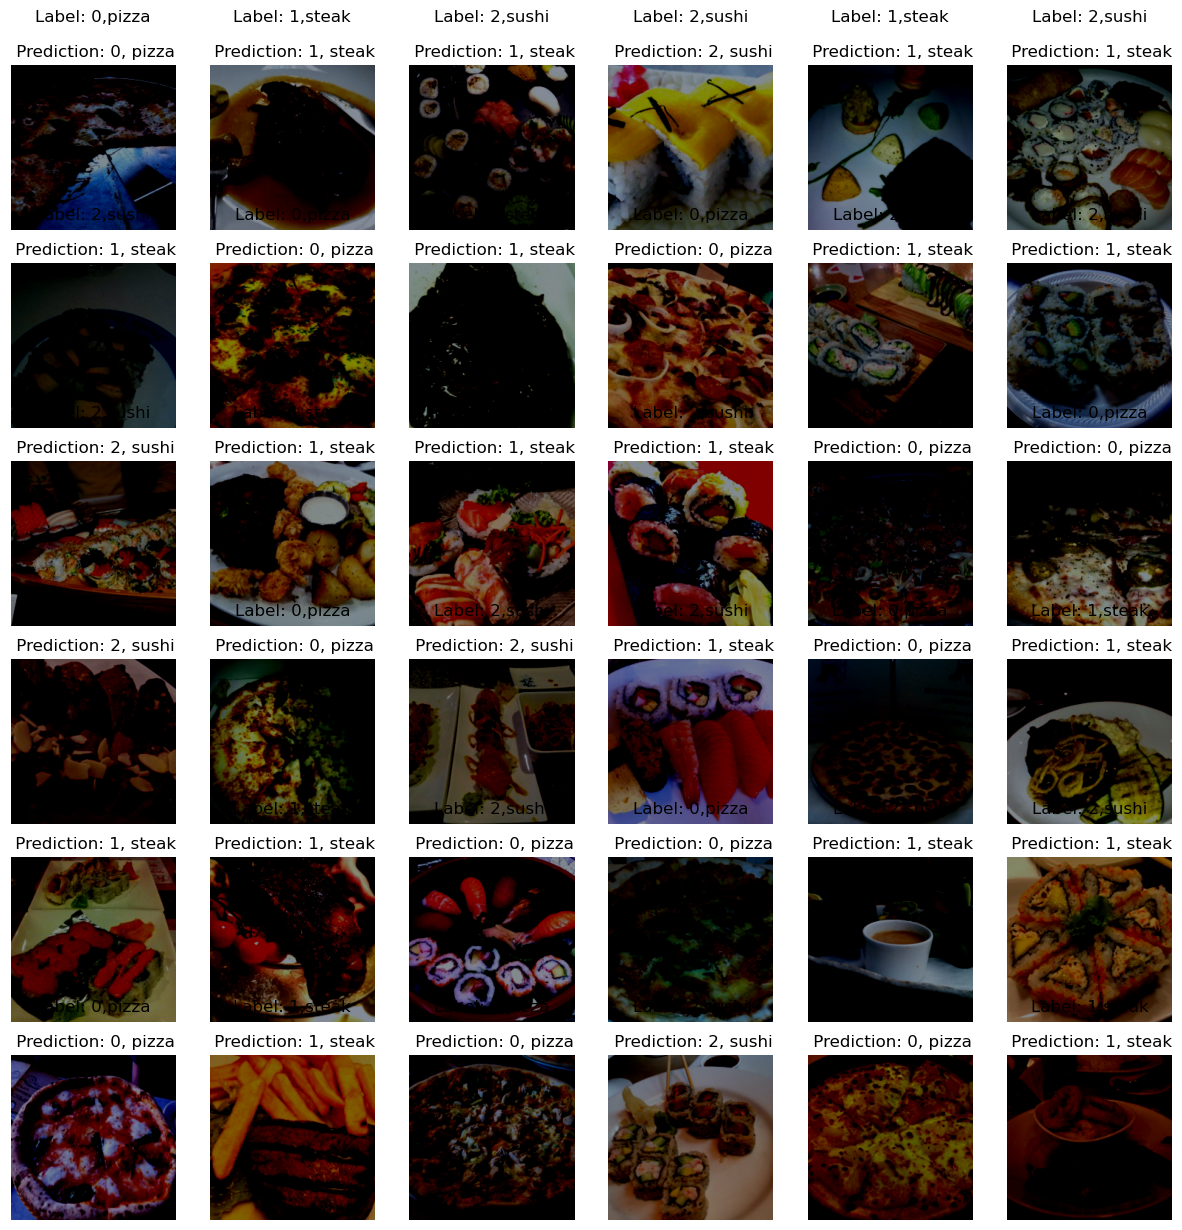

In [25]:
# infere

for i, (inputs, labels) in enumerate(eval_dataloader_pretrained):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = pretrained_vit(inputs)
    _, preds = torch.max(outputs, 1)
    print(preds)
    print(labels)
    print(f"Accuracy: {torch.sum(preds == labels).item() / len(preds)*100:.2f}%")
    # plot half a batch
    length = len(inputs) // 2
    plt.figure(figsize=(15, 15))
    for i in range(length):
        plt.subplot(int(length**0.5), int(length**0.5), i + 1)
        img = inputs[i].to("cpu")
        # revert normalization
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.title(
            f"""Label: {labels[i].item()},{class_names[labels[i].item()]}
            \n Prediction: {preds[i].item()}, {class_names[preds[i].item()]}"""
        )
        plt.axis("off")

    break

In [ ]:
lllll

## STOP HERE

In [ ]:
from torch.nn import functional as F


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cl1 = nn.Linear(25, 60)
        self.cl2 = nn.Linear(60, 16)
        self.fc1 = nn.Linear(16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.cl1(x))
        x = F.relu(self.cl2(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output

    return hook


layer = "fc3"
model = MyModel()
model.fc3.register_forward_hook(get_activation(layer))
x = torch.randn(1, 25)
output = model(x)
print(activation["fc3"].shape)
print(output.shape)

In [ ]:
activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output

    return hook

In [ ]:
activation = {}

In [ ]:
vit.encoder.layers[0]

In [ ]:
vit = pretrained_vit
vit.encoder.layers[0].register_forward_hook(get_activation("self_attention"))
# activation = {}

In [ ]:
torch.manual_seed(42)
x = torch.randn(1, 3, 224, 224).to(device)
output = vit(x)
print(output)
y = activation["self_attention"]
print(y.shape)

In [ ]:
y[0].shape

In [ ]:
vit.encoder.layers[0].self_attention

In [ ]:
vit.register_forward_hook(get_activation("encoder.encoder_layer_11"))

In [ ]:
import numpy as np

activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


x = train_dataloader_pretrained.dataset[0][0].unsqueeze(0).to(device)
pretrained_vit.encoder.register_forward_hook(get_activation("encoder"))
preds = pretrained_vit(x)
img = activation["encoder"]
print(img.shape)
# reshape img to 3x224x224
img = img[:, 1:].reshape(3, 224, 224)
# convert to numpy
img = img.cpu().numpy()
# transpose to 224x224x3
img = np.transpose(img, (1, 2, 0))
# cdot with x
img = img * x.cpu().numpy().squeeze().transpose((1, 2, 0))
# plot the image
plt.imshow(img)
plt.show()

In [ ]:
activation = {}
for i in range(12):
    vit.encoder.layers[i].register_forward_hook(
        get_activation("self_attention{}.output".format(i))
    )

In [ ]:
activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output

    return hook

In [ ]:
activation[0]

In [ ]:
alpha = [activation["self_attention{}.output".format(i + 1)] for i in range(12)]
# alpha = torch.cat(alpha, dim=0)
alpha.shape